In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

# hyperparameters
K = 3
N_e = 100
N_i = N_e
N = N_e + N_i
D = 30
sparsity = 0.25
U = 200
T = 100
N_weights = int (N * N * sparsity)
max_iter=50

zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2.5)) for i in list(np.arange(-1.5,0.5,0.25))]

In [2]:
# colormap = ['tab:green','tab:blue','tab:red','tab:brown']
# fig, axes = plt.subplots(1, figsize=(14,6))
# i = 0
# for distr in ['normal']:
#     K = 10
#     n_sim = 5000
#     norm_A = np.zeros((n_sim))
#     nonnormality_A = np.zeros((n_sim))
#     for sim in range(n_sim):
#         eig = generate_eigenvalues(K=10)
#         A, norm_A[sim], nonnormality_A[sim] = generate_dynamics_A(eigenvalues=eig, normal=False)

#     # axes[0].hist(norm_A, color=colormap[i], label=distr, alpha=0.4, bins=20)
#     axes.hist(nonnormality_A, color=colormap[i], label=distr, alpha=0.4, bins=20)

#     i+= 1
# # axes[0].legend()
# # axes.set_ylim(0,100)
# axes.legend()

In [3]:
K_values = [1,2,3,5,15,25] 
color_dict = {1:'tab:purple',2:'tab:pink',3:'tab:cyan',5:'yellowgreen', 15:'olive', 25:'tab:brown'}
color_dict_j = {0:'gold',1:'tab:red',2:'tab:orange'}
j_values = [0,1,2]
J_possibility_title = np.array(['normal', 'normal + co-act', 'uniform'])
num_simulations=50

In [4]:
def load_data(N, K_values, j_values, num_simulations, parameter='w'):
    data_interest = np.empty((len(K_values), len(j_values), num_simulations), dtype=object)
    for k in range(len(K_values)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                data_interest[k, j, simulation] = np.load(f'models/N={N}_K={K_values[k]}_parameters_simulation_{simulation}_J_possibility_{j_values[j]}.npz', allow_pickle=True)[parameter]
    return data_interest

w = load_data(N, K_values=[1], j_values=j_values, num_simulations=num_simulations, parameter='w')

# # fit W
# fitW = np.empty((len(K_values), len(j_values), num_simulations), dtype=object)
# v = np.empty((len(j_values), num_simulations), dtype=object)
# for j in j_values:
#     for simulation in range(num_simulations):
#         RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[j, simulation], seed=1)

#         fitW[j, simulation] = RNN.build_full_weight_matrix(w[j,simulation])

#         # eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
#         # ones = np.ones((v_concat.shape[1]))
#         # idx = np.argsort(eigval_PCA)[::-1]
#         # eigval_PCA = eigval_PCA[idx]
#         # eigvec_PCA = eigvec_PCA[:,idx]




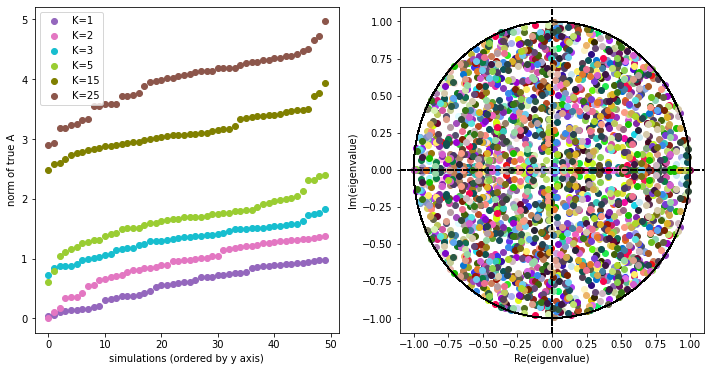

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_norm_eig(axes, num_simulations, K_vals=[1]):
    trueA = load_data(N, K_values=K_vals, j_values=[0], num_simulations=num_simulations, parameter='trueA')
    for k in range(len(K_vals)):
        norm_A = np.zeros((num_simulations))
        for simulation in range(norm_A.shape[0]):
            norm_A[simulation] = np.linalg.norm(trueA[k,0,simulation])
            eigval = np.linalg.eigvals(trueA[k,0,simulation])
            plot_eigenvalues(axes[1], eigval, color=generate_random_color(), label='')
        idx = np.argsort(norm_A)
        axes[0].scatter(range(num_simulations), norm_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_ylabel('norm of true A')
        axes[0].set_xlabel('simulations (ordered by y axis)')
    axes[0].legend(loc='upper left')

K_vals = K_values.copy()
plot_true_A_norm_eig(axes, num_simulations, K_vals=K_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

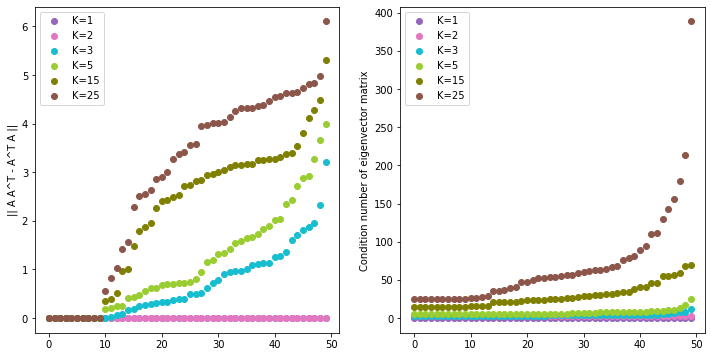

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_non_normality(axes, num_simulations, K_vals=[1]):
    trueA = load_data(N, K_values=K_vals, j_values=[0], num_simulations=num_simulations, parameter='trueA')
    for k in range(len(K_vals)):
        non_normality1_A = np.zeros((num_simulations)) # commutator
        non_normality2_A = np.zeros((num_simulations)) # non orthogonality of eigenvectors via condition number
        for simulation in range(non_normality1_A.shape[0]):
            non_normality1_A[simulation] = np.linalg.norm(trueA[k,0,simulation] @ np.transpose(trueA[k,0,simulation]) - np.transpose(trueA[k,0,simulation]) @ trueA[k,0,simulation]) 
            if K_vals[k] != 1:
                _, eigvec = np.linalg.eig(trueA[k,0,simulation])
                non_normality2_A[simulation] = np.linalg.norm(eigvec) * np.linalg.norm(np.linalg.inv(eigvec))
        idx = np.argsort(non_normality1_A)
        axes[0].scatter(range(num_simulations), non_normality1_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_ylabel('|| A A^T - A^T A ||')
        idx = np.argsort(non_normality2_A)
        axes[1].scatter(range(num_simulations), non_normality2_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[1].set_ylabel('Condition number of eigenvector matrix')
        axes[0].legend(loc='upper left')
        axes[1].legend(loc='upper left')

K_vals = K_values.copy()
plot_true_A_non_normality(axes, num_simulations, K_vals=K_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_non_normality', bbox_inches='tight', dpi=300)
    


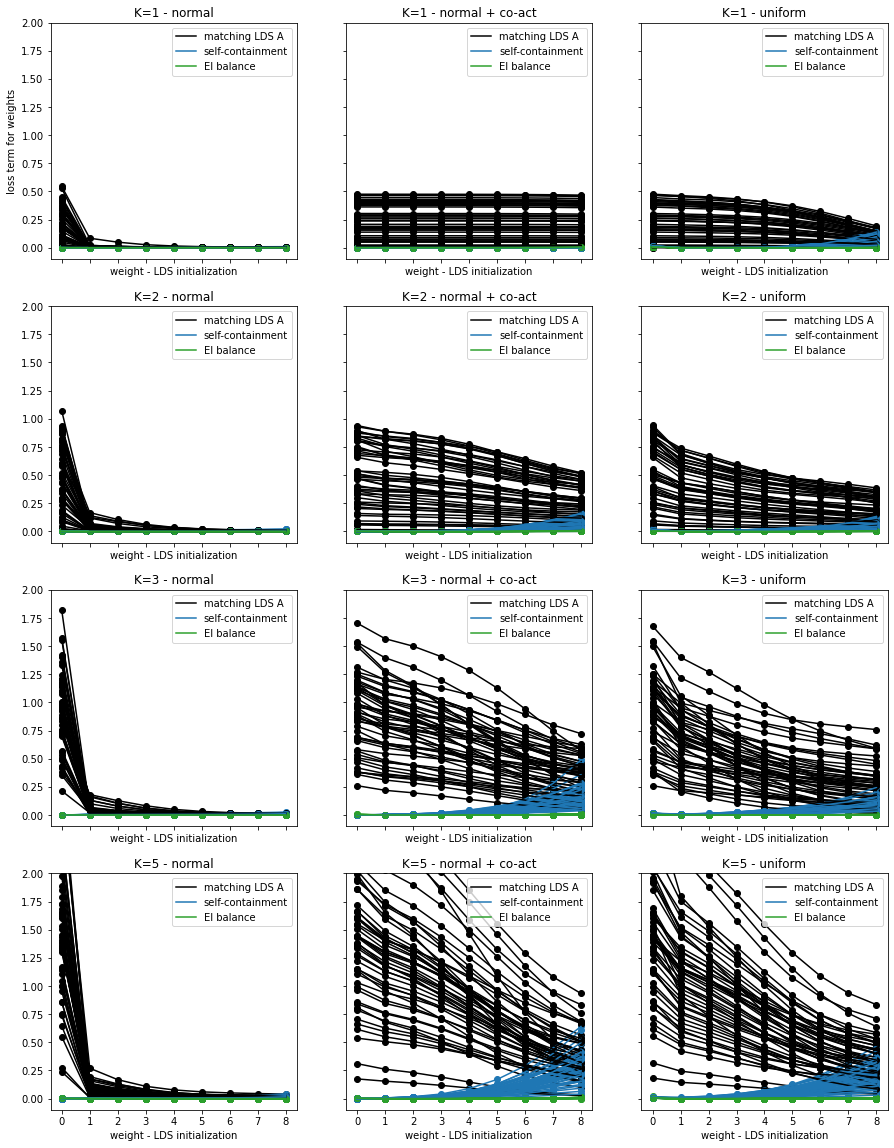

In [7]:
def plot_initialization_loss(axes, num_simulations, K_vals, j_values, zeta_alpha_beta_gamma_list):
    loss_W = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='loss_W')

    # Ensure axes is a 2D array for consistent indexing
    if len(K_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(K_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(K_vals), len(j_values)))

    for k in range(len(K_vals)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 0:
                    axes[k,j].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black', label='matching LDS A')
                    axes[k,j].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black')
                    axes[k,j].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue', label='self-containment')
                    axes[k,j].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue')
                    axes[k,j].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green', label='EI balance')
                    axes[k,j].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green')
                else:
                    axes[k,j].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black')
                    axes[k,j].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black')
                    axes[k,j].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue')
                    axes[k,j].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue')
                    axes[k,j].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green')
                    axes[k,j].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green')

                axes[k,j].set_xlabel('weight - LDS initialization')
                axes[k,j].set_xticks(range(loss_W[k,j,simulation][:,0].shape[0]),range(loss_W[k,j,simulation][:,0].shape[0]))
                axes[k,j].legend(loc='upper right')
                axes[k,j].set_title(f'J variation {j}')
                axes[k,j].set_title(f'K={K_vals[k]} - ' + J_possibility_title[j_values[j]])

            axes[0,0].set_ylabel('loss term for weights')
            axes[0,0].set_ylim(-0.1,2)
K_vals = [1,2,3,5]
j_vals = [0,1,2]
fig, axes = plt.subplots(len(K_vals), len(j_vals), figsize=(5 * len(j_vals), 5 * len(K_vals)), sharey=True, sharex= True)
plot_initialization_loss(axes, num_simulations, K_vals=K_vals, j_values=j_vals, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
# plt.savefig(f'figures/N={N}_K={K}_figure=1_plot_plot_initialization_loss', bbox_inches='tight', dpi=300)



/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


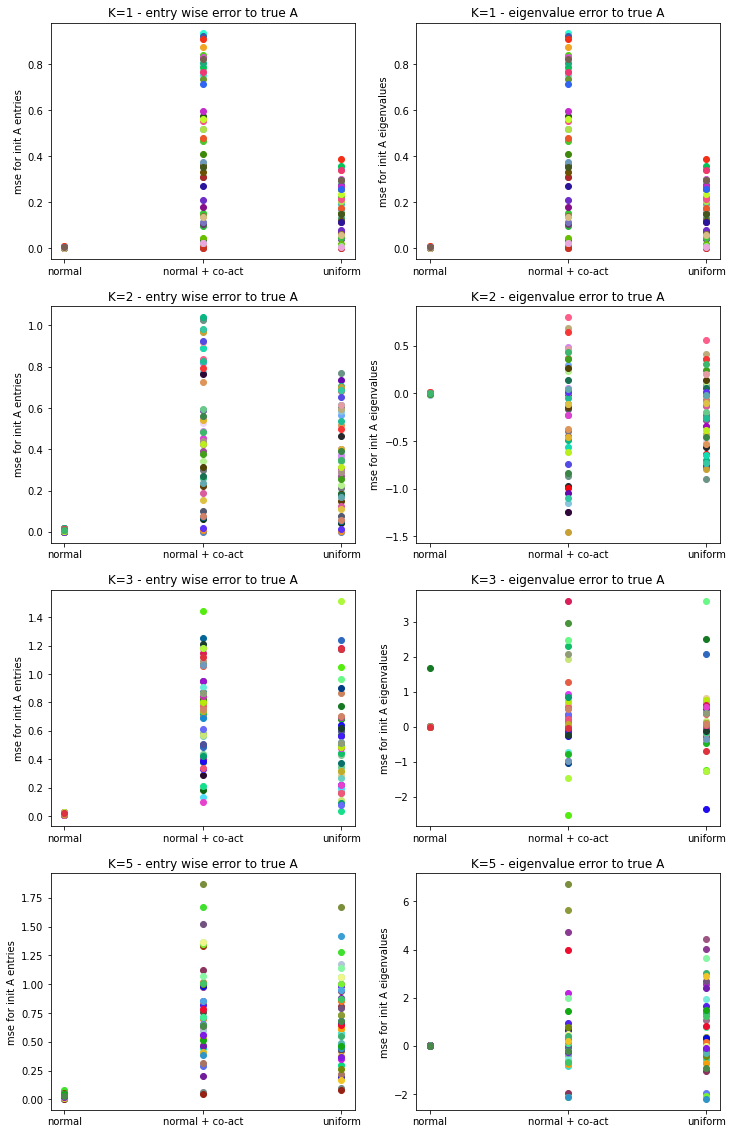

In [8]:
def plot_dynamics_initialization_error(axes, num_simulations, K_vals, j_values=[0,1]):
    J = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='J')
    trueA = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='trueA')
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')

    if len(K_vals) == 1:
        axes = axes.reshape((len(K_vals), 2))

    for k in range(len(K_vals)):
        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                initA = build_dynamics_matrix_A(initW[k,j, simulation], J[k,j, simulation])
                axes[k,0].scatter(j, mse(initA, trueA[k,j, simulation]), color=color)

                # got to order eigenvalues to best match each other and do a different metric
                axes[k,1].scatter(j, mse(np.linalg.eigvals(initA).reshape(1,initA.shape[0]), np.linalg.eigvals(trueA[k,j,simulation]).reshape(1,initA.shape[0])), color=color)

                axes[k,0].set_xticks(j_values, J_possibility_title[j_values])
                axes[k,1].set_xticks(j_values, J_possibility_title[j_values])
        
            axes[k,0].set_ylabel('mse for init A entries')
            axes[k,1].set_ylabel('mse for init A eigenvalues')
            axes[k,0].set_title(f'K={K_vals[k]} - entry wise error to true A')
            axes[k,1].set_title(f'K={K_vals[k]} - eigenvalue error to true A')

K_vals = [1,2,3,5]
j_vals = [0,1]
fig, axes = plt.subplots(len(K_vals), 2, figsize=(12, 5 * len(K_vals)))
plot_dynamics_initialization_error(axes, num_simulations, K_vals=K_vals, j_values=j_values)
# plt.savefig(f'figures/N={N}_K={K}_figure=2_plot_dynamics_initialization_error', bbox_inches='tight', dpi=300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


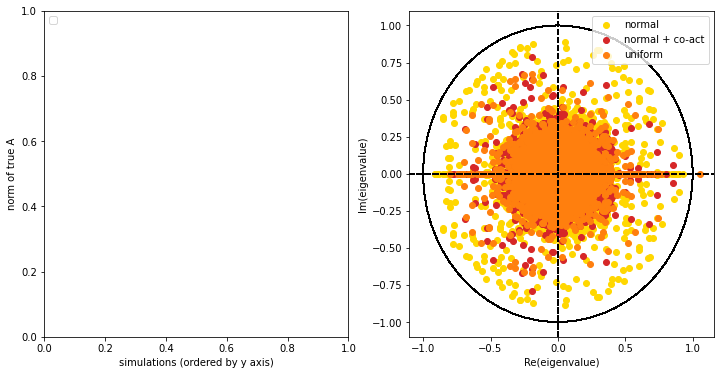

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_W_eig(axes, num_simulations, K_vals=[1], j_values=[0]):
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')
    for j in range(len(j_values)):
        for k in range(len(K_vals)):
            norm_W = np.zeros((num_simulations))
            for simulation in range(num_simulations):
                norm_W = np.linalg.norm(initW[k,j,simulation])
                eigval = np.linalg.eigvals(initW[k,j,simulation])
                if simulation == 0 and k == 0:
                    plot_eigenvalues(axes[1], eigval,  color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                else:
                    plot_eigenvalues(axes[1], eigval,  color=color_dict_j.get(j_values[j]))
            idx = np.argsort(norm_W)
            # axes[0].scatter(range(num_simulations), norm_W[idx], color=color_dict_j.get(j_values[j]), label=f'j={j_values[j]}')
            axes[0].set_ylabel('norm of true A')
            axes[0].set_xlabel('simulations (ordered by y axis)')
        axes[0].legend(loc='upper left')
        axes[1].legend()

K_vals = [1,2,3,5]
plot_W_eig(axes, num_simulations, K_vals=K_vals, j_values=[0,1,2])
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

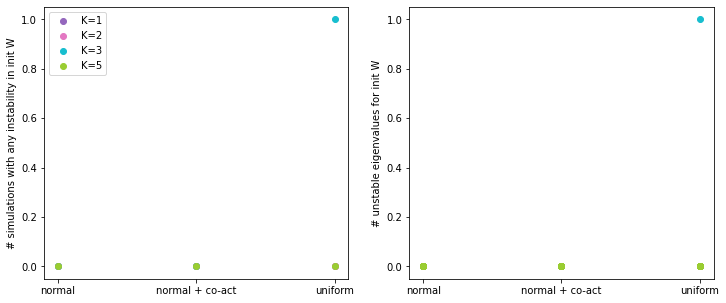

In [10]:
def plot_unstable_initializations(axes, num_simulations, K_vals, j_values=[0,1]):
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')
    for k in range(len(K_vals)):
        binary_unstable_init = np.zeros((len(j_values), num_simulations))
        count_unstable_init = np.zeros((len(j_values), num_simulations))

        for simulation in range(num_simulations):
            for j in range(len(j_values)):
                binary_unstable_init[j, simulation], count_unstable_init[j, simulation] = check_unstable(initW[k,j,simulation])
                axes[1].scatter(j, count_unstable_init[j, simulation], color=color_dict.get(K_vals[k]))
            
        axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_xticks(j_values, J_possibility_title[j_values])
        axes[1].set_xticks(j_values, J_possibility_title[j_values])
        axes[0].set_ylabel('# simulations with any instability in init W')
        axes[1].set_ylabel('# unstable eigenvalues for init W')
        axes[0].legend(loc='upper left')

fig, axes = plt.subplots(1,2, figsize=(12, 5))
K_vals = [1,2,3,5]
j_vals = [0,1,2] 
plot_unstable_initializations(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)




In [23]:
# # whether instability in fitting is solely caused by instability in initialization

0
1
2
3


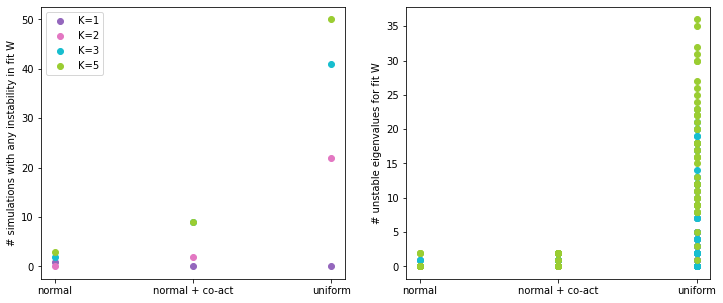

In [12]:
def plot_unstable_fitting(axes, num_simulations, K_vals, j_values=[0,1]):
    w = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='w')
    J = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='J')

    for k in range(len(K_vals)):
        print(k)
        binary_unstable_init = np.zeros((len(j_values), num_simulations))
        count_unstable_init = np.zeros((len(j_values), num_simulations))

        for simulation in range(num_simulations):
            for j in range(len(j_values)):
                RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[k,j, simulation], seed=1)
                fitW = RNN.build_full_weight_matrix(w[k,j,simulation])
                binary_unstable_init[j, simulation], count_unstable_init[j, simulation] = check_unstable(fitW)
                axes[1].scatter(j, count_unstable_init[j, simulation], color=color_dict.get(K_vals[k]))
            
        axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_xticks(j_values, J_possibility_title[j_values])
        axes[1].set_xticks(j_values, J_possibility_title[j_values])
        axes[0].set_ylabel('# simulations with any instability in fit W')
        axes[1].set_ylabel('# unstable eigenvalues for fit W')
        axes[0].legend(loc='upper left')

fig, axes = plt.subplots(1,2, figsize=(12, 5))
K_vals = [1,2,3,5]
j_vals = [0,1,2] 
plot_unstable_fitting(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)



# plt.savefig(f'figures/N={N}_K={K}_figure=4_plot_unstable_fitting', bbox_inches='tight', dpi=300)


ValueError: operands could not be broadcast together with shapes (2,2) (4,30) 

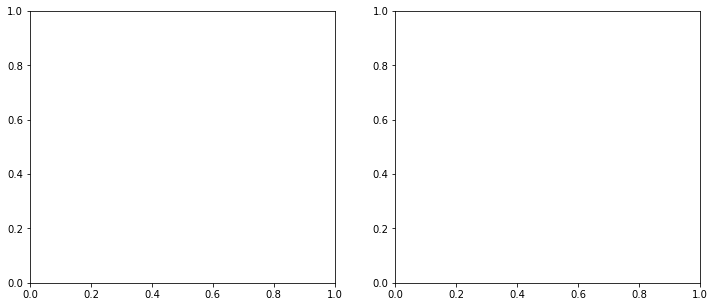

In [30]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
def plot_fit_dynamics_error(axes, trueA, fitW, j_values=[0,1]):
    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            fitA = build_dynamics_matrix_A(fitW[j, simulation], J[j, simulation])

            axes[0].scatter(j, mse(fitA, trueA[j,simulation]), color=color)
            axes[1].scatter(j, mse(np.linalg.eigvals(fitA).reshape(1,fitA.shape[0]), np.linalg.eigvals(trueA[j,simulation]).reshape(1,fitA.shape[0])), color=color)
            axes[0].set_xticks(j_values, J_possibility_title[j_values])
            axes[1].set_xticks(j_values, J_possibility_title[j_values])
       
        axes[0].set_ylabel('mse for fit A entries')
        axes[1].set_ylabel('mse for fit A eigenvalues')

plot_fit_dynamics_error(axes, trueA, fitW, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=5_plot_fit_dynamics_error', bbox_inches='tight', dpi=300)


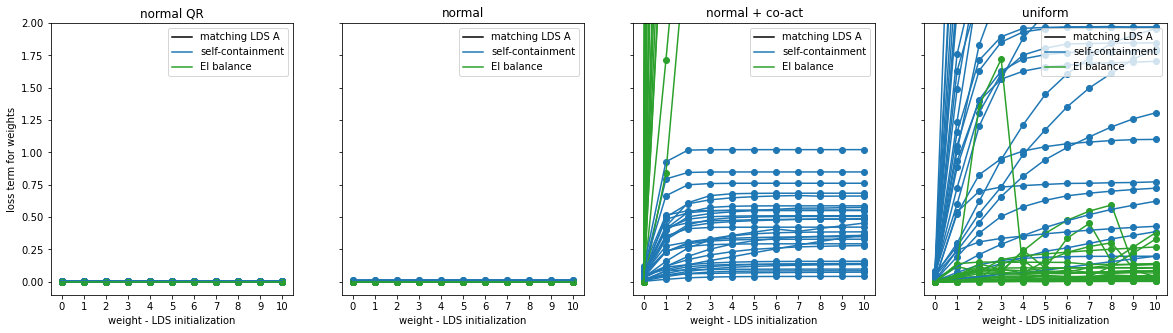

In [26]:
fig, axes = plt.subplots(1, len(j_values), figsize=(5 * len(j_values),5), sharey=True)
lossW = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='lossW')

def plot_fitting_loss(axes, lossW, j_values, zeta_alpha_beta_gamma_list):
    j_count = 0
    for j in j_values:
        for simulation in range(loss_W.shape[1]):
            if simulation == 0:
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,0], color='black', label='matching LDS A')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,0], color='black')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue', label='self-containment')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green', label='EI balance')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green')
            else:
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,0], color='black')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,0], color='black')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green')

            axes[j_count].set_xlabel('weight - LDS initialization')
            axes[j_count].set_xticks(range(lossW[j,simulation][:,0].shape[0]),range(lossW[j,simulation][:,0].shape[0]))
            axes[j_count].legend(loc='upper right')
            axes[j_count].set_title(f'J variation {j}')
            axes[j_count].set_title(J_possibility_title[j])

        j_count += 1
        axes[0].set_ylabel('loss term for weights')
        axes[0].set_ylim(-0.1,2)

plot_fitting_loss(axes, lossW, j_values=j_values, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_fitting_loss', bbox_inches='tight', dpi=300)




In [27]:
# def plot_error_parameters(b, s, mu0, Q0, C_, d, R):


# b = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='b')
# s = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='s')
# mu0 = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='mu0')
# Q0 = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='Q0')
# C_ = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='C_')
# d = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='d')
# R = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='R')


# for eig in range(3):
#     fig, axes = plt.subplots(figsize=(5,5))
#     for simulation in range(30):
#         if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: 
#             plot_mse_parameters(axes, b[eig,simulation].item(), s[eig,simulation], mu0[eig,simulation], Q0[eig,simulation], C_[eig,simulation], d[eig,simulation], R[eig,simulation], true_b[eig,simulation].item(), true_s[eig,simulation], true_mu0[eig,simulation], true_Q0[eig,simulation], true_C_[eig,simulation], true_d[eig,simulation], true_R[eig,simulation])

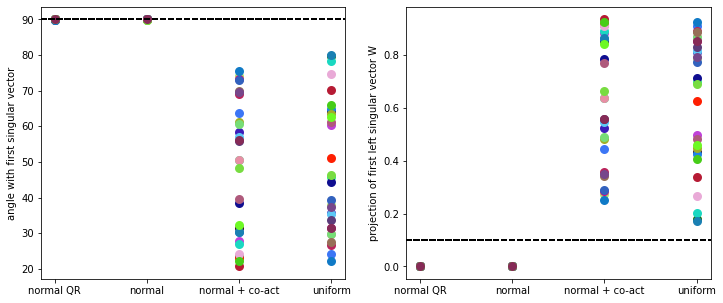

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_relationship_W_J(axes, fitW, J, j_values=[0,1]):
    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            # ones = np.ones((J[0,0].shape[1]))
            # v_proj, angle = projection_on_subspace(ones, J[j,simulation])
            # axes[0].scatter(j, np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)
            
            U, s, Vh = np.linalg.svd(fitW[j,simulation])
            v_proj, angle = projection_on_subspace(U[:,0],J[j,simulation])
            axes[0].scatter(j, angle, color=color, linewidth=3)
            axes[1].scatter(j, np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color=color, linewidth=3)

            axes[0].axhline(90, color='black', linestyle='dashed', label='')
            axes[1].axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')

        axes[0].set_xticks(j_values, J_possibility_title[j_values])
        axes[1].set_xticks(j_values, J_possibility_title[j_values])
        axes[0].set_ylabel('angle with first singular vector')
        axes[1].set_ylabel('projection of first left singular vector W')

plot_relationship_W_J(axes, fitW, J, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=7_plot_relationship_W_J', bbox_inches='tight', dpi=300)


# fig, axes = plt.subplots(figsize=(5,6))
# for k in range(K):
#     v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
#     axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

# v_proj, angle = projection_on_subspace(ones, J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)

# v_proj, angle = projection_on_subspace(U[:,0],J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color='yellow', label=f'first singular vector W', linewidth=3)


# axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
# axes.set_ylabel('length of projection on subspace J')
# # axes.set_ylim(0,120)
# axes.set_xticks([],[])
# # axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
# axes.legend()

In [29]:

def PCA_cluster():
    eigvec_PCA = 
# PCA on network activity
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))

# variance explained in PCA
fig, axes = plt.subplots(figsize=(7,5))
var_explained_pc = np.zeros((v_concat.shape[1]))
cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
axes2 = axes.twinx()
for i in range(var_explained_pc.shape[0]):
    var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
    cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
axes.plot(range(25), var_explained_pc[:25], color='black')
axes.scatter(range(25), var_explained_pc[:25], label='individual', color='black')
axes2.plot(range(25), cumul_var_explained_pc[:25], color='gray')
axes2.scatter(range(25), cumul_var_explained_pc[:25], label='cumulative', color='gray')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_ylabel('variance explained')
axes2.set_ylabel('cumulative variance explained')
axes.set_xlabel('PC dimension')
axes.set_xticks([0,1,2,3,4,5,9,14,19,24],[1,2,3,4,5,6,10,15,20,25])
axes2.set_ylim(0,1)
axes.set_title('PCA on network activity')

SyntaxError: invalid syntax (2063622070.py, line 2)

In [ ]:
# alignment of two subspaces - variance explained in projection (for stable weights)

fraction_cov_var_PCA = np.zeros((10, 30))
fraction_cov_var_J = np.zeros((10, 30))
for eig in range(3):
    for simulation in range(30):
        

        if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: # both init and fit weights are stable
            RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig, simulation],  seed=1)
            # print(fitW[eig, simulation].shape)
            # print(mu0[eig, simulation].shape)
            # print(Q0[eig, simulation].shape)
            v = RNN.generate_network_activity(U, T, fitW[eig, simulation], b[eig, simulation].item(), float(s[eig, simulation]), mu0[eig, simulation], Q0[eig, simulation])

            # PCA on data
            v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
            # v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
            # mean = v_avg.mean(axis=0)
            mean = v_concat.mean(axis=0)

            # mean-center
            v_concat = v_concat - mean
            # v_mean = v_avg - mean

            eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
            ones = np.ones((v_concat.shape[1]))
            # eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
            # ones = np.ones((v_mean.shape[1]))
            idx = np.argsort(eigval_PCA)[::-1]
            eigval_PCA = eigval_PCA[idx]
            eigvec_PCA = eigvec_PCA[:,idx]

            dim_PCA = 3

            fraction_cov_var_J[eig, simulation], fraction_cov_var_PCA[eig,simulation] = covariance_alignment(v_concat, J[eig,simulation], eigvec_PCA[:,:dim_PCA])

            # # variance explained in PCA
            # fig, axes = plt.subplots(figsize=(7,5))
            # var_explained_pc = np.zeros((v_concat.shape[1]))
            # cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
            # axes2 = axes.twinx()
            # for i in range(var_explained_pc.shape[0]):
            #     var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
            #     cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
            # axes.plot(range(10), var_explained_pc[:10], color='black')
            # axes.scatter(range(10), var_explained_pc[:10], label='individual', color='black')
            # axes2.plot(range(10), cumul_var_explained_pc[:10], color='gray')
            # axes2.scatter(range(10), cumul_var_explained_pc[:10], label='cumulative', color='gray')
            # axes.axhline(0, color='black', linestyle='dashed')
            # axes.set_ylabel('variance explained')
            # axes2.set_ylabel('cumulative variance explained')
            # axes.set_xlabel('PC dimension')
            # axes.set_xticks(range(10),range(1,11))
            # axes2.set_ylim(0,1.05)
            # axes.set_title(f'PCA on network - eig set = {eig}')
            

KeyboardInterrupt: 

In [99]:
print(fraction_cov_var_J.shape)
print(fraction_cov_var_PCA.shape)

(10, 30)
()


(0.0, 0.7)

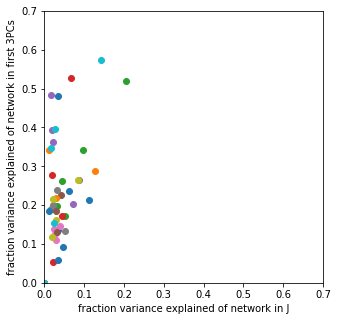

In [108]:
fig, axes = plt.subplots(figsize=(5,5))
for eig in range(10):
    for simulation in range(30):
        axes.scatter(fraction_cov_var_J[eig,simulation],fraction_cov_var_PCA[eig,simulation])
axes.set_xlabel('fraction variance explained of network in J')
axes.set_ylabel('fraction variance explained of network in first 3PCs')
axes.set_xlim(0,0.7)
axes.set_ylim(0,0.7)